<font color=green>

# CLASSIFICATION USING KFOLDS AND RANDOM FOREST
<br></font>
Same as always but a bit different

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #I don't care about the new version of Pandas that cannot execute things
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore',category=ConvergenceWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import seaborn as sns

import sklearn.tree
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_absolute_error, classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GroupShuffleSplit, KFold, StratifiedKFold, GridSearchCV

## UK

### Scripted

#### GAD-7

In [3]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-KCL-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

Feature_File.insert(0, "Label", "NaN", True)
category = "GAD7"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"     

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','PHQ8','IDS'])
feature_names = Feature_File.columns

In [6]:
n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.044231 
train confusion matrix:
[[1036   15    1    0]
 [  14 1067    1    3]
 [  25   31  528    2]
 [   8   28   10  351]]
test error: 0.371795 
test confusion matrix:
[[193  59   6   4]
 [ 61 193  13   3]
 [ 19  64  50   5]
 [ 10  29  17  54]]
TRAINING
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1052
           1       0.94      0.98      0.96      1085
           2       0.98      0.90      0.94       586
           3       0.99      0.88      0.93       397

    accuracy                           0.96      3120
   macro avg       0.96      0.94      0.95      3120
weighted avg       0.96      0.96      0.96      3120


TESTING
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       262
           1       0.56      0.71      0.63       270
           2       0.58      0.36      0.45       138
           3       0.82      0.49      0.61       110

    accuracy 

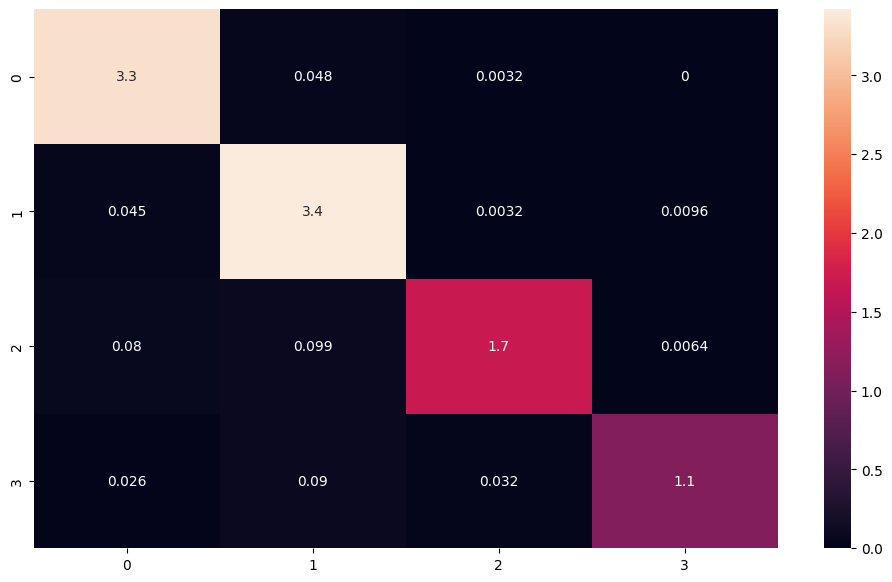

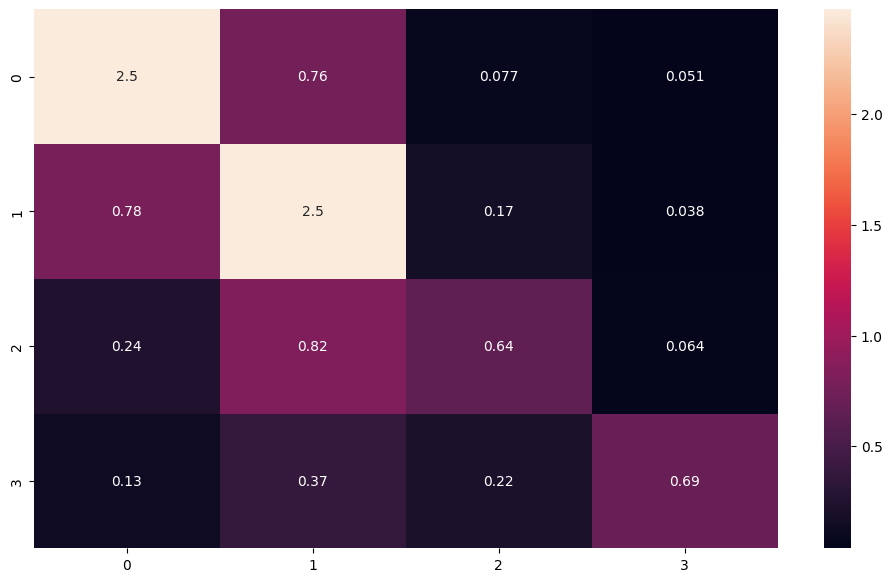

In [9]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### PHQ-8

In [13]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-KCL-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1
Feature_File.insert(0, "Label", "NaN", True)
category = "PHQ8"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"     


is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','IDS'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')


                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0


c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.052564 
train confusion matrix:
[[826  11   1   0   0]
 [  7 959   3   3   0]
 [  5  20 638   0   0]
 [ 10  25  14 397   1]
 [ 10  32  15   7 136]]
test error: 0.533333 
test confusion matrix:
[[132  64  12   3   1]
 [ 51 138  31  12   1]
 [ 13  90  55  20   1]
 [ 11  40  25  28   3]
 [  3  19   8   8  11]]
TRAINING
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       838
           1       0.92      0.99      0.95       972
           2       0.95      0.96      0.96       663
           3       0.98      0.89      0.93       447
           4       0.99      0.68      0.81       200

    accuracy                           0.95      3120
   macro avg       0.96      0.90      0.92      3120
weighted avg       0.95      0.95      0.95      3120


TESTING
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       212
           1       0.39      0.59      0.47       233
      

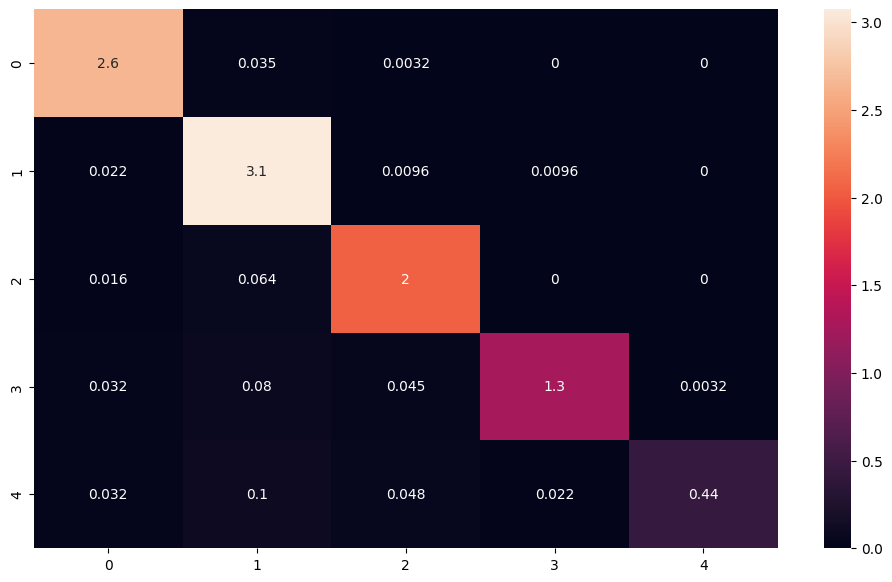

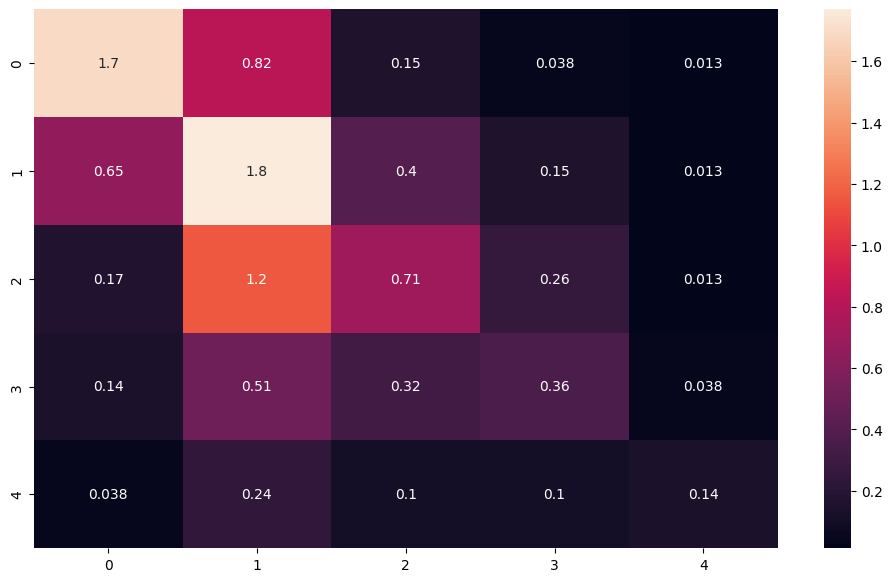

In [14]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3","4"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### IDS

In [53]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-KCL-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','PHQ8'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0



c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [54]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss   Training    Testing
0    R2   0.007544   0.006718
1   MSE  72.992657  72.992657
2  RMSE   5.402942   5.402942
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [55]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_IDS_uk_s = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['IDS','IDS', 'IDS'],
    'Country': ['UK','UK','UK'],
    'Task':['Scripted', 'Scripted', 'Scripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_IDS_uk_s)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country      Task
0    r2   0.682701    0.443727     GAD-7      UK  Scripted
1   MSE  11.572584   19.611949     GAD-7      UK  Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK  Scripted
0    r2   0.682701    0.443727     PHQ-8      UK  Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK  Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK  Scripted
0    r2   0.773765    0.616806       IDS      UK  Scripted
1   MSE  42.009521   71.722529       IDS      UK  Scripted
2  RMSE   6.481475    8.468915       IDS      UK  Scripted


### Unscripted

#### GAD-7

In [4]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-KCL-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1
Feature_File.insert(0, "Label", "NaN", True)

category = "GAD7"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','PHQ8','IDS'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.045768 
train confusion matrix:
[[898  12   1   1]
 [  8 971   1   3]
 [ 15  30 462   7]
 [ 13  26   9 296]]
test error: 0.370640 
test confusion matrix:
[[176  58   7   1]
 [ 48 181  10   5]
 [ 15  53  39   7]
 [  7  32  12  37]]
TRAINING
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       912
           1       0.93      0.99      0.96       983
           2       0.98      0.90      0.94       514
           3       0.96      0.86      0.91       344

    accuracy                           0.95      2753
   macro avg       0.96      0.93      0.94      2753
weighted avg       0.96      0.95      0.95      2753


TESTING
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       242
           1       0.56      0.74      0.64       244
           2       0.57      0.34      0.43       114
           3       0.74      0.42      0.54        88

    accuracy                 

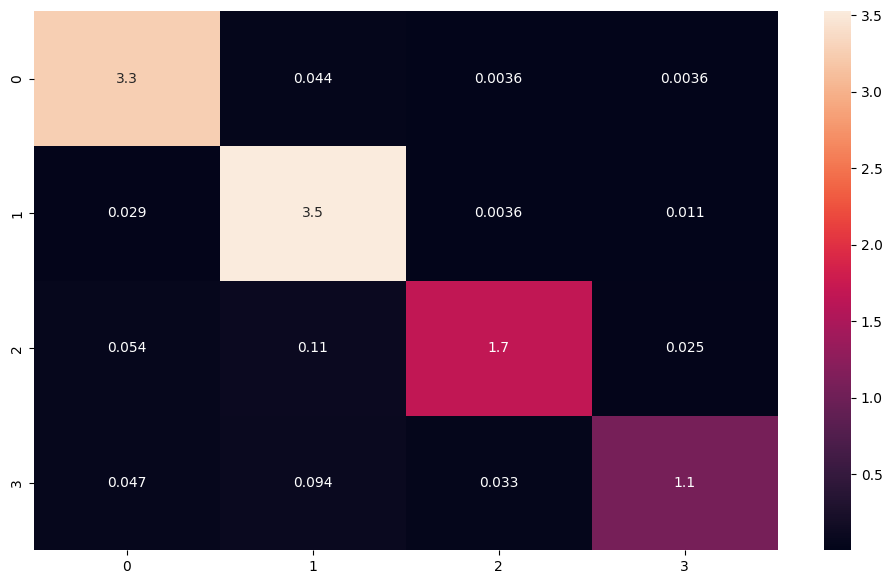

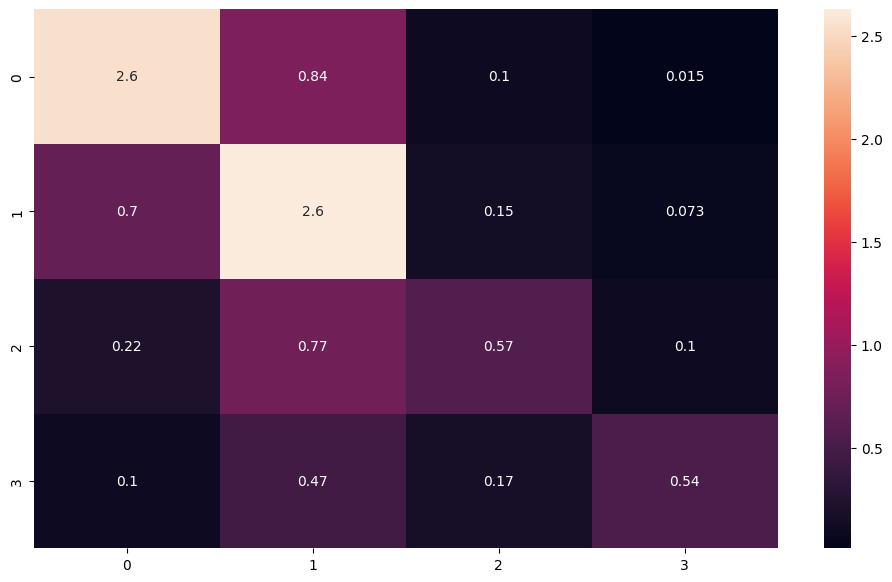

In [5]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### PHQ-8

In [6]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-KCL-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1
Feature_File.insert(0, "Label", "NaN", True)

category = "PHQ8"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','IDS'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')
                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.047948 
train confusion matrix:
[[747   9   1   0   0]
 [  7 848   4   0   0]
 [ 10  12 580   0   0]
 [ 11  20   9 317   0]
 [  8  30   6   5 129]]
test error: 0.543605 
test confusion matrix:
[[122  63  13   1   0]
 [ 61 125  21   5   0]
 [ 16  73  43  11   1]
 [ 10  40  22  16   1]
 [  4  11  14   7   8]]
TRAINING
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       757
           1       0.92      0.99      0.95       859
           2       0.97      0.96      0.97       602
           3       0.98      0.89      0.93       357
           4       1.00      0.72      0.84       178

    accuracy                           0.95      2753
   macro avg       0.97      0.91      0.93      2753
weighted avg       0.95      0.95      0.95      2753


TESTING
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       199
           1       0.40      0.59      0.48       212
      

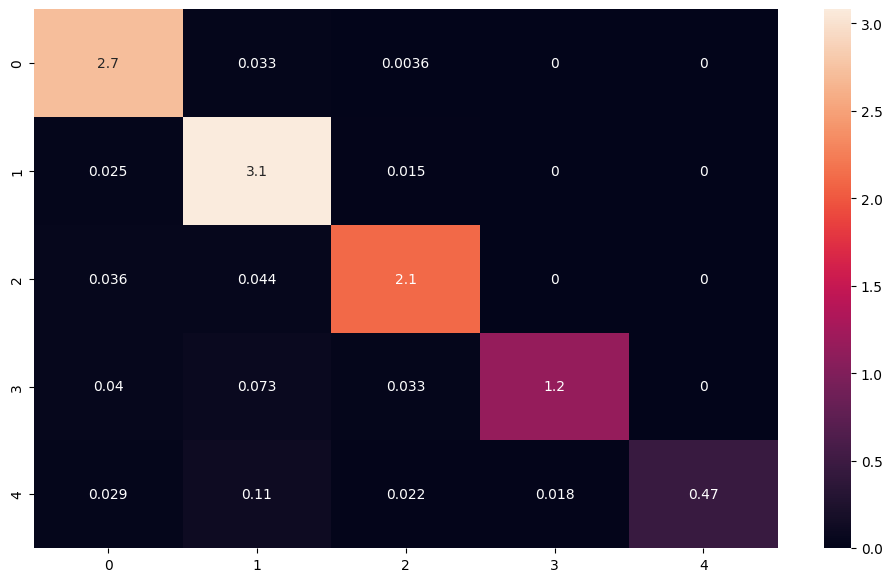

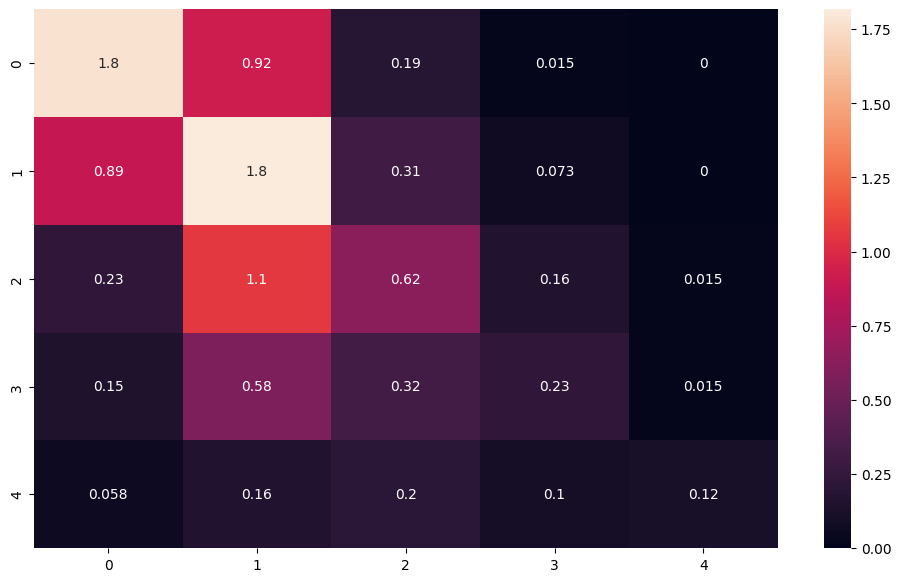

In [7]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3","4"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### IDS

In [65]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-KCL-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','PHQ8'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [66]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss   Training    Testing
0    R2   0.015154   0.013774
1   MSE  70.020994  70.020994
2  RMSE   5.291942   5.291942
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [67]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_IDS_uk_u = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['IDS','IDS', 'IDS'],
    'Country': ['UK','UK','UK'],
    'Task':['Unscripted', 'Unscripted', 'Unsripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_IDS_uk_u)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

### Results for UK

In [68]:
results_gad7_uk_s.to_excel('Results_Classification_UK.xlsx', index=False, na_rep='NaN')

## ESP

### Scripted

#### PHQ-8

In [8]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-CIBER-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-IISPV-s1-18_04_2022_v3.xlsx')
Feature_File_3 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = pd.concat([Feature_File_1, Feature_File_2])
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index'])

Feature_File.insert(0, "Label", "NaN", True)

category = "PHQ8"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"   

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','PHQ8','IDS'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.042724 
train confusion matrix:
[[116   3   0   0   0]
 [  6 173   2   2   0]
 [  0   3 165   2   0]
 [  0   1   5 145   1]
 [  0   2   0   5 118]]
test error: 0.459893 
test confusion matrix:
[[12  9  2  2  0]
 [ 7 31  5  4  0]
 [ 1  8 25 10  0]
 [ 3  7 10 16  4]
 [ 0  3  4  7 17]]
TRAINING
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       119
           1       0.95      0.95      0.95       183
           2       0.96      0.97      0.96       170
           3       0.94      0.95      0.95       152
           4       0.99      0.94      0.97       125

    accuracy                           0.96       749
   macro avg       0.96      0.96      0.96       749
weighted avg       0.96      0.96      0.96       749


TESTING
              precision    recall  f1-score   support

           0       0.52      0.48      0.50        25
           1       0.53      0.66      0.59        47
           2       0.54      0.

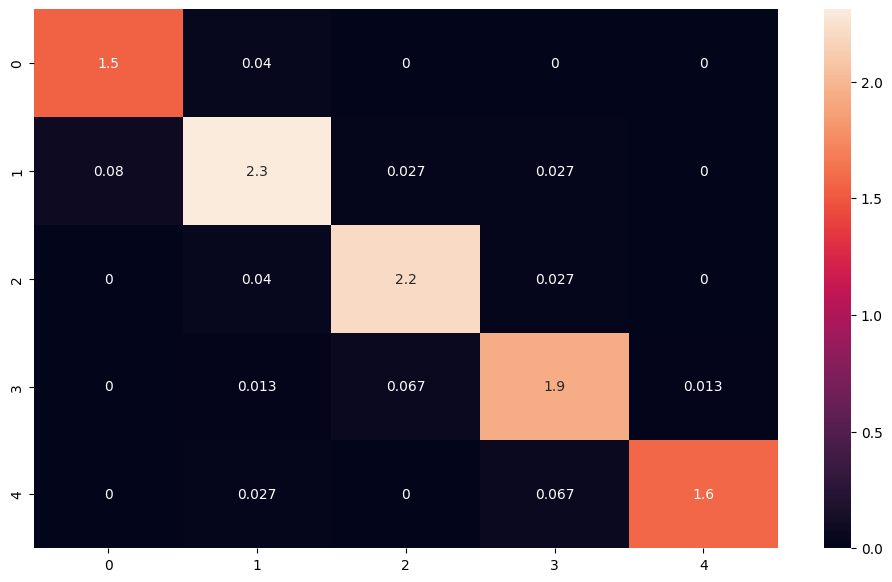

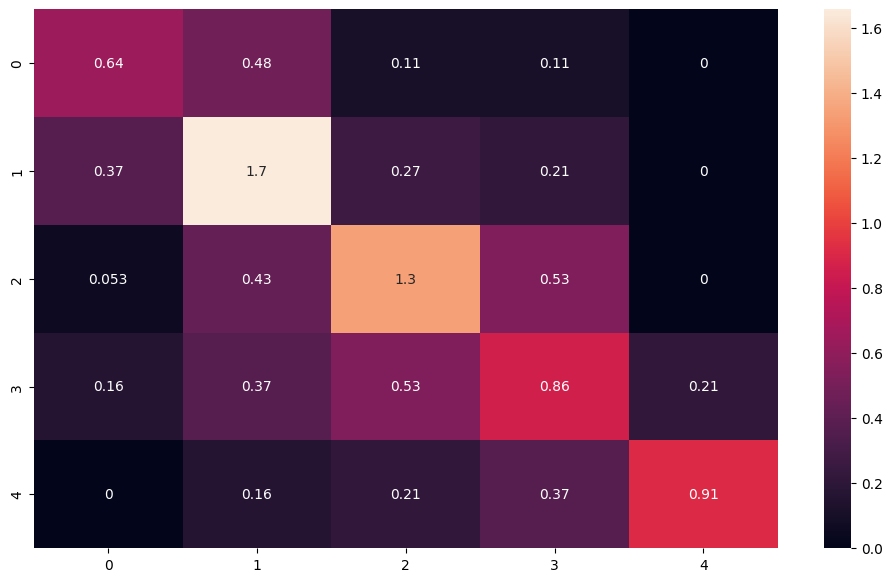

In [9]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3","4"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### GAD-7

In [10]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-CIBER-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-IISPV-s1-18_04_2022_v3.xlsx')
Feature_File_3 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = pd.concat([Feature_File_1, Feature_File_2])
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index'])

Feature_File.insert(0, "Label", "NaN", True)

category = "GAD7"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"   


is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','IDS'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.052069 
train confusion matrix:
[[141   3   1   2]
 [  3 175   3   9]
 [  2   4 157   9]
 [  1   0   2 237]]
test error: 0.363636 
test confusion matrix:
[[21  7  0 10]
 [ 3 28  2 14]
 [ 5  4 19 13]
 [ 2  2  6 51]]
TRAINING
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       147
           1       0.96      0.92      0.94       190
           2       0.96      0.91      0.94       172
           3       0.92      0.99      0.95       240

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749


TESTING
              precision    recall  f1-score   support

           0       0.68      0.55      0.61        38
           1       0.68      0.60      0.64        47
           2       0.70      0.46      0.56        41
           3       0.58      0.84      0.68        61

    accuracy                           0.64  

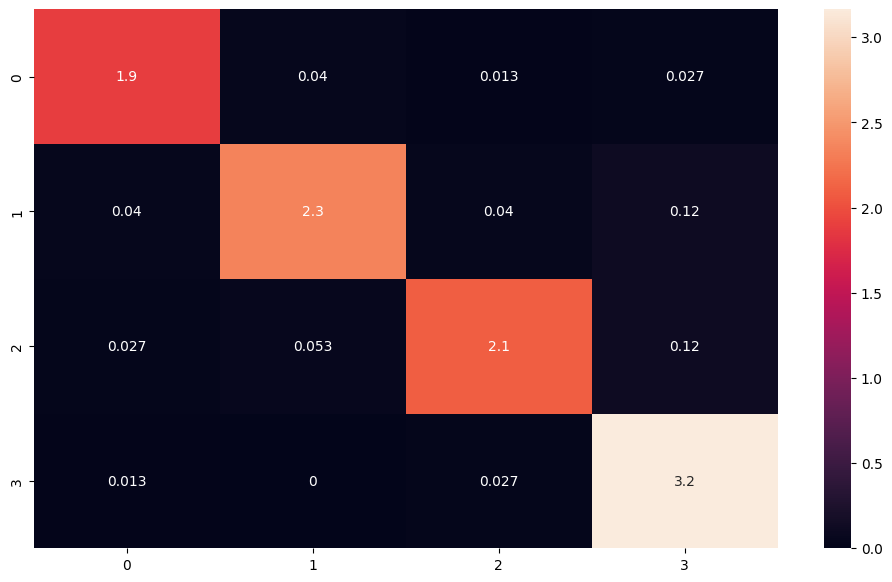

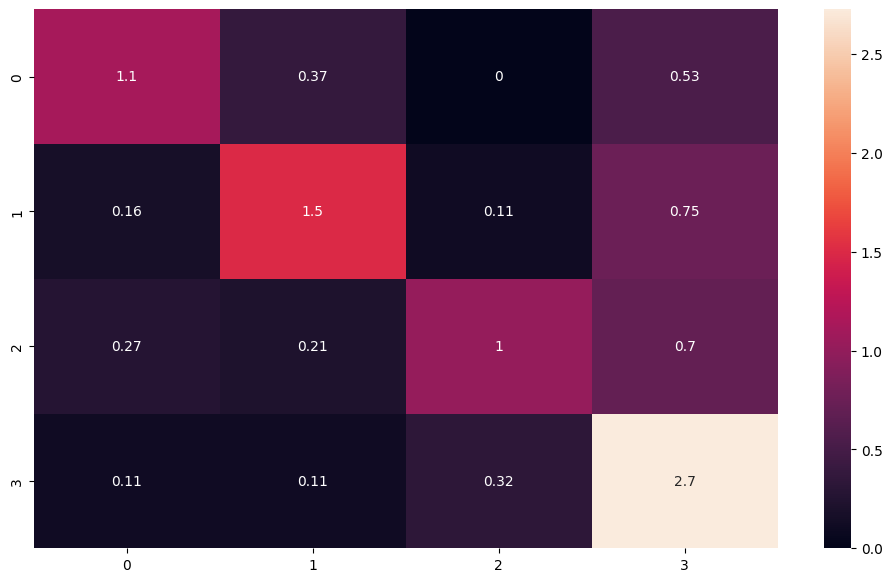

In [11]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### IDS

In [75]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-CIBER-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-IISPV-s1-18_04_2022_v3.xlsx')
Feature_File_3 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = pd.concat([Feature_File_1, Feature_File_2])
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index'])

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','PHQ8'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [76]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss    Training     Testing
0    R2    0.019726    0.017094
1   MSE  101.981183  101.981183
2  RMSE    6.384702    6.384702
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [77]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_IDS_esp_s = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['IDS','IDS', 'IDS'],
    'Country': ['ESP','ESP','ESP'],
    'Task':['Scripted', 'Scripted', 'Scripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_IDS_esp_s)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

### Unscripted

#### GAD-7

In [12]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-CIBER-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-IISPV-s1-18_04_2022_v3.xlsx')
Feature_File_3 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = pd.concat([Feature_File_1, Feature_File_2])
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index'])

Feature_File.insert(0, "Label", "NaN", True)

category = "GAD7"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"   


is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','IDS','PHQ8'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')


                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.065719 
train confusion matrix:
[[102   2   0   2]
 [  3 147   3   4]
 [  2   5 101  10]
 [  0   3   3 176]]
test error: 0.342857 
test confusion matrix:
[[16 11  1  2]
 [ 3 22  2  7]
 [ 2  2 20  9]
 [ 2  5  2 34]]
TRAINING
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       106
           1       0.94      0.94      0.94       157
           2       0.94      0.86      0.90       118
           3       0.92      0.97      0.94       182

    accuracy                           0.93       563
   macro avg       0.94      0.93      0.93       563
weighted avg       0.93      0.93      0.93       563


TESTING
              precision    recall  f1-score   support

           0       0.70      0.53      0.60        30
           1       0.55      0.65      0.59        34
           2       0.80      0.61      0.69        33
           3       0.65      0.79      0.72        43

    accuracy                           0.66  

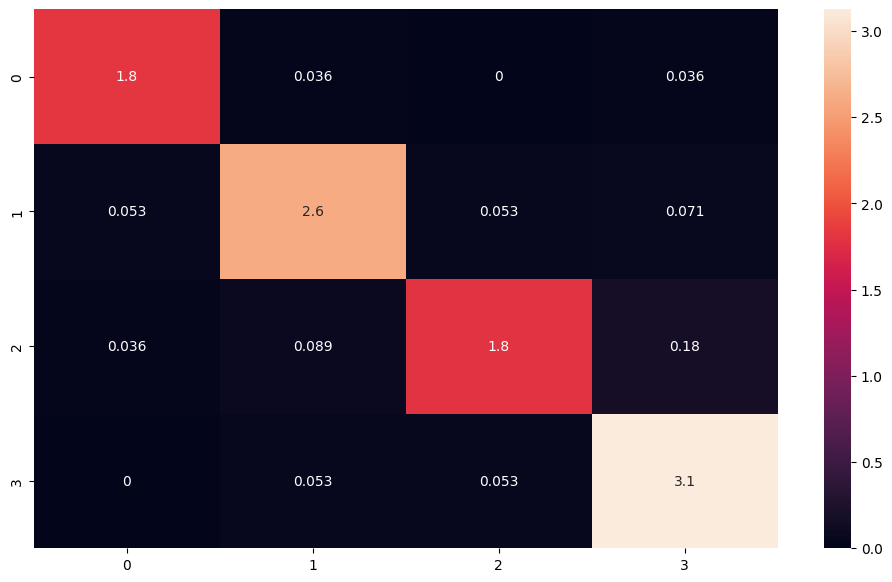

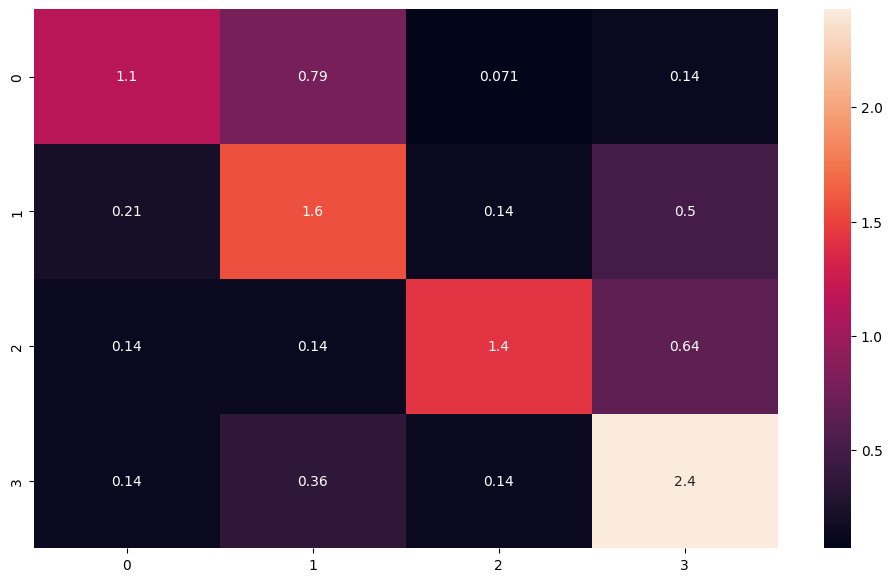

In [14]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### PHQ-8

In [15]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-CIBER-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-IISPV-s1-18_04_2022_v3.xlsx')
Feature_File_3 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = pd.concat([Feature_File_1, Feature_File_2])
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index'])

Feature_File.insert(0, "Label", "NaN", True)

category = "PHQ8"

if category == "PHQ8":
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] <= 19 and Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"    
        elif Feature_File.loc[index_FE, category] <= 24 and Feature_File.loc[index_FE, category] > 19:
            Feature_File.loc[index_FE, 'Label'] = "4"
        else:
            Feature_File.loc[index_FE, 'Label'] = "NaN"
elif category == "GAD7":            
    for index_FE, row_FE in Feature_File.iterrows():
        if Feature_File.loc[index_FE, category] <= 4:
            Feature_File.loc[index_FE, 'Label'] = "0"
        elif Feature_File.loc[index_FE, category] <= 9 and Feature_File.loc[index_FE, category] > 4:
            Feature_File.loc[index_FE, 'Label'] = "1"
        elif Feature_File.loc[index_FE, category] <= 14 and Feature_File.loc[index_FE, category] > 9:
            Feature_File.loc[index_FE, 'Label'] = "2"
        elif Feature_File.loc[index_FE, category] > 14:
            Feature_File.loc[index_FE, 'Label'] = "3"   


is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','IDS','GAD7'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,1]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 2:32]
    y_train = Feature_File.iloc[train_index, 0]
    X_val = Feature_File.iloc[test_index, 2:32]
    y_val = Feature_File.iloc[test_index, 0]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestClassifier(
                        n_estimators=est, 
                        criterion='entropy', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    scorer = sklearn.metrics.make_scorer(accuracy_score, average = 'weighted')


                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


train error: 0.044405 
train confusion matrix:
[[101   1   0   1   0]
 [  4 111   4   1   0]
 [  0   2 120   1   0]
 [  1   0   3 114   1]
 [  0   1   1   4  92]]
test error: 0.478571 
test confusion matrix:
[[14  7  2  2  0]
 [ 5 15  4  7  2]
 [ 2  5 14  7  1]
 [ 0  3  6 15  2]
 [ 1  1  5  5 15]]
TRAINING
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       103
           1       0.97      0.93      0.94       120
           2       0.94      0.98      0.96       123
           3       0.94      0.96      0.95       119
           4       0.99      0.94      0.96        98

    accuracy                           0.96       563
   macro avg       0.96      0.96      0.96       563
weighted avg       0.96      0.96      0.96       563


TESTING
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        25
           1       0.48      0.45      0.47        33
           2       0.45      0.

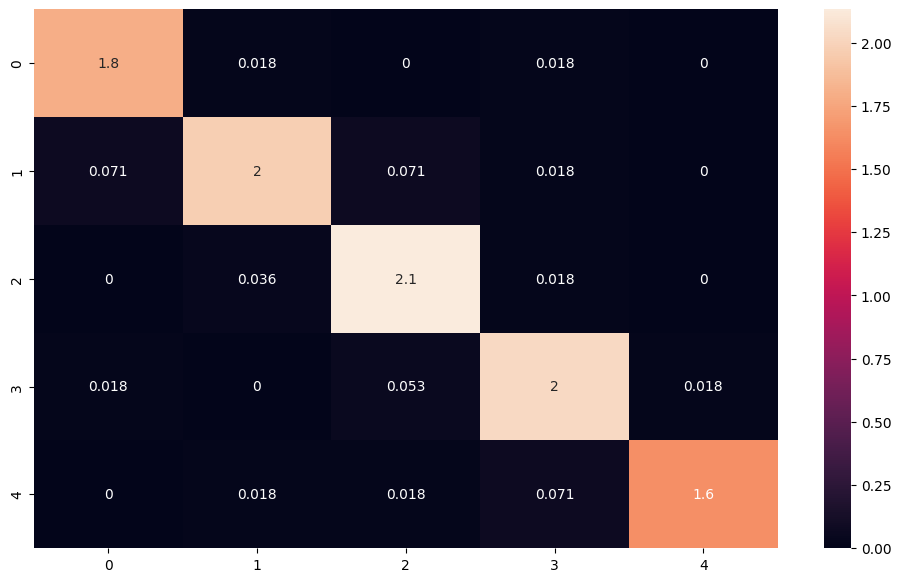

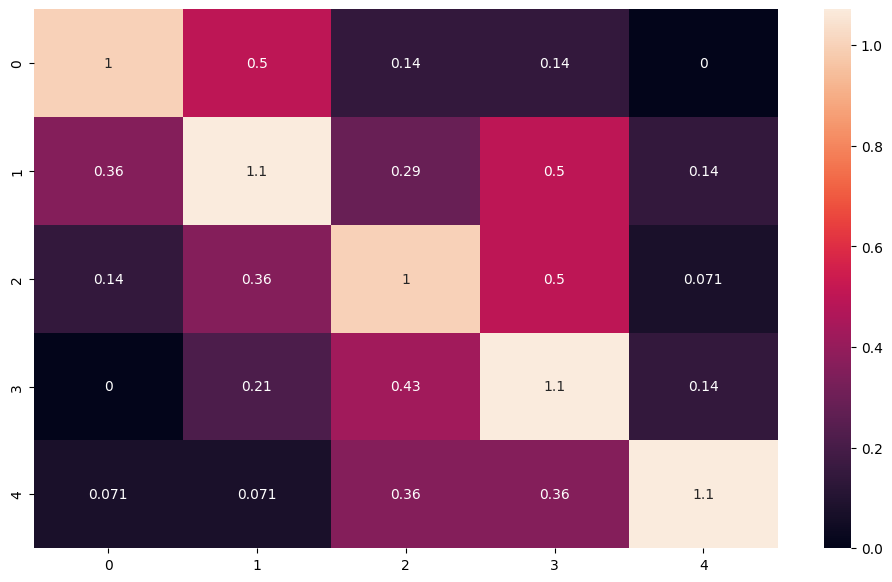

In [16]:
import seaborn as sn
# Make the predictions over both datasets
rnd_clf = sklearn.ensemble.RandomForestClassifier(criterion='entropy',min_samples_leaf=5, random_state=1)
rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_test = rnd_clf.predict(X_val)
# Compute errors and confusion matrices
train_error = 1. - accuracy_score(y_train, pred_train)
train_cmat = confusion_matrix(y_train, pred_train)
test_error = 1. - accuracy_score(y_val, pred_test)
test_cmat = confusion_matrix(y_val, pred_test)

classes_anx = ["0","1","2","3","4"]

df_cm = pd.DataFrame(train_cmat/np.sum(train_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Training')

df_cm = pd.DataFrame(test_cmat/np.sum(test_cmat)*10,index = [i for i in classes_anx], columns=[i for i in classes_anx])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion Matrix Anxiety Test')

print('train error: %f ' % train_error)
print('train confusion matrix:')
print(train_cmat)
print('test error: %f ' % test_error)
print('test confusion matrix:')
print(test_cmat)

# Prinf classification report
print("TRAINING\n" + classification_report(y_train, pred_train))
print("\nTESTING\n" + classification_report(y_val, pred_test))

#### IDS

In [84]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-CIBER-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-IISPV-s1-18_04_2022_v3.xlsx')
Feature_File_3 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = pd.concat([Feature_File_1, Feature_File_2])
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index'])

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','PHQ8'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0

c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [85]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss    Training     Testing
0    R2    0.023441    0.017542
1   MSE  108.210203  108.210203
2  RMSE    6.577690    6.577690
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [86]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_IDS_esp_u = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['IDS','IDS', 'IDS'],
    'Country': ['ESP','ESP','ESP'],
    'Task':['Unscripted', 'Unscripted', 'Unscripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_IDS_esp_u)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

In [87]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/")    
results_gad7_uk_s.to_excel('Results_Classification.xlsx', index=False, na_rep='NaN')

## NL

### Scripted

#### GAD-7

In [88]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-VUmc-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','PHQ8','IDS'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0


c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [89]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss  Training   Testing
0    R2  0.005687  0.003472
1   MSE  9.046903  9.046903
2  RMSE  1.902256  1.902256
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [90]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_GAD7_NL_S = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['GAD-7','GAD-7', 'GAD-7'],
    'Country': ['NL','NL','NL'],
    'Task':['Scripted', 'Scripted', 'Scripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_GAD7_NL_S)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

#### PHQ-8

In [91]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-VUmc-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','IDS'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0


c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [92]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss   Training    Testing
0    R2   0.007615   0.005699
1   MSE  11.721852  11.721852
2  RMSE   2.165105   2.165105
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [93]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_PHQ8_NL_S = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['PHQ-8','PHQ-8', 'PHQ-8'],
    'Country': ['NL','NL','NL'],
    'Task':['Scripted', 'Scripted', 'Scripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_PHQ8_NL_S)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

#### IDS

In [94]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Scripted-RADAR-MDD-VUmc-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','GAD7','PHQ8'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0


c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [95]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss   Training    Testing
0    R2   0.014022   0.010949
1   MSE  64.576438  64.576438
2  RMSE   5.081948   5.081948
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [96]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_IDS_NL_S = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['IDS','IDS', 'IDS'],
    'Country': ['NL','NL','NL'],
    'Task':['Scripted', 'Scripted', 'Scripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_IDS_NL_S)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

### Unscripted

#### GAD-7

In [97]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-VUmc-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','IDS','PHQ8'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0


c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [98]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss  Training   Testing
0    R2  0.012725  0.010186
1   MSE  8.232506  8.232506
2  RMSE  1.814424  1.814424
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [99]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_GAD7_NL_U = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['GAD-7','GAD-7', 'GAD-7'],
    'Country': ['NL','NL','NL'],
    'Task':['Unscripted', 'Unscripted', 'Unscripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_GAD7_NL_U)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

#### PHQ-8

In [100]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-VUmc-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','IDS','GAD7'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0


c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [101]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss   Training    Testing
0    R2   0.018396   0.011762
1   MSE  10.625575  10.625575
2  RMSE   2.061062   2.061062
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [102]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_PHQ8_NL_U = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['PHQ-8','PHQ-8', 'PHQ-8'],
    'Country': ['NL','NL','NL'],
    'Task':['Unscripted', 'Unscripted', 'Unscripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_PHQ8_NL_U)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

#### IDS

In [103]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/Originals_changed")        
Feature_File_1 = pd.read_excel('MDD_Praat-Unscripted-RADAR-MDD-VUmc-s1-18_04_2022_v3.xlsx')
Feature_File_2 = pd.read_excel('MDD-eGeMAPS-Scores-Scripted-RADAR-MDD-KCL-s1-27_01_2022_v3.xlsx',index_col=0)
Feature_File = Feature_File_1

is_NaN = Feature_File.isnull()     
row_has_NaN = is_NaN.any(axis=1)
NaN_index =  row_has_NaN[row_has_NaN].index.values
Feature_File.drop(NaN_index, inplace=True)

delete_rows = []
for index_FE, row_FE in Feature_File.iterrows():
    if Feature_File.loc[index_FE,'Duration'] < 2:
        delete_rows.append(index_FE)
Feature_File = Feature_File.drop(delete_rows) 
Feature_File = Feature_File.reset_index()
Feature_File = Feature_File.drop(columns=['index','Site','Recording_Date','Task','PHQ8','GAD7'])
feature_names = Feature_File.columns

n_fold = 5
kf_Strat = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

max_leaf_nodes = [52, 62, 72, 82, 92, 100]
min_samples_split = [2,3,4,5,10]
max_features = [0.3, 0.5, 0.75, 1.0]
n_estimators = [30, 50, 75, 85, 100]

r2_score_train = np.zeros((1500,n_fold), dtype=float)
mse_score_train = np.zeros((1500,n_fold), dtype=float)
rmse_score_train = np.zeros((1500,n_fold), dtype=float)
r2_score_test = np.zeros((1500,n_fold), dtype=float)
mse_score_test = np.zeros((1500,n_fold), dtype=float)
rmse_score_test = np.zeros((1500,n_fold), dtype=float)

param = []

fld_cnt = 0
for train_index, test_index in kf_Strat.split(Feature_File, Feature_File.iloc[:,0]):
    print("Processing fold" + str((fld_cnt+1)))

    X_train = Feature_File.iloc[train_index, 1:32]
    y_train = Feature_File.iloc[train_index, 33]
    X_val = Feature_File.iloc[test_index, 1:32]
    y_val = Feature_File.iloc[test_index, 33]

    st_x = StandardScaler()
    X_train = st_x.fit_transform(X_train)
    X_val = st_x.transform(X_val)

    grid_cnt = 0
    print("...................... RANDOM FOREST")
    for est in n_estimators:
        for leaf in max_leaf_nodes:
            for samples in min_samples_split:
                for feat in max_features:
                    if fld_cnt == 0:
                        param.append([est, leaf, samples, feat])

                    rnd_clf = sklearn.ensemble.RandomForestRegressor(
                        n_estimators=est, 
                        criterion='squared_error', 
                        random_state=0, 
                        max_features=feat,
                        max_leaf_nodes=leaf, 
                        max_samples=samples,
                        bootstrap=True
                    )
                    rnd_clf.fit(X_train, y_train)
                    pred_train = rnd_clf.predict(X_train)
                    pred_test = rnd_clf.predict(X_val)

                    r2_score_train[grid_cnt, fld_cnt] = r2_score(y_train, pred_train, multioutput='variance_weighted')
                    r2_score_test[grid_cnt, fld_cnt] = r2_score(y_val, pred_test, multioutput='variance_weighted')
                    mse_score_train[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    mse_score_test[grid_cnt, fld_cnt] = mean_squared_error(y_train, pred_train)
                    rmse_score_train[grid_cnt, fld_cnt] = np.sqrt(mse_score_train[grid_cnt, fld_cnt])
                    rmse_score_test[grid_cnt, fld_cnt] = np.sqrt(mse_score_test[grid_cnt, fld_cnt])

                    grid_cnt += 1
    fld_cnt += 1
    grid_cnt = 0


c:\Users\ericq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Processing fold1
...................... RANDOM FOREST
Processing fold2
...................... RANDOM FOREST
Processing fold3
...................... RANDOM FOREST
Processing fold4
...................... RANDOM FOREST
Processing fold5
...................... RANDOM FOREST


In [104]:
mean_r2_score_train = np.mean(r2_score_train)
mean_r2_score_test = np.mean(r2_score_test)
mean_mse_score_train = np.mean(mse_score_train)
mean_mse_score_test = np.mean(mse_score_test)
mean_rmse_score_train = np.mean(rmse_score_train)
mean_rmse_score_test = np.mean(rmse_score_test)

scores = pd.DataFrame({
    'Loss':['R2','MSE','RMSE'],
    'Training':[mean_r2_score_train,mean_mse_score_train, mean_rmse_score_train],
    'Testing':[mean_r2_score_test, mean_mse_score_test, mean_rmse_score_train]
})

print(scores)

mean_r2_score_train = np.mean(r2_score_train, axis=1)
mean_r2_score_test = np.mean(r2_score_test, axis=1)
mean_mse_score_train = np.mean(mse_score_train, axis=1)
mean_mse_score_test = np.mean(mse_score_test, axis=1)
mean_rmse_score_train = np.mean(rmse_score_train, axis=1)
mean_rmse_score_test = np.mean(rmse_score_test, axis=1)

min_ind_RF = np.argmin(mean_rmse_score_test)
print(min_ind_RF)
try:
    final_param_RF = param[min_ind_RF]
except:
    final_param_RF = param[min_ind_RF-1]

print("Best parameters:" + "\nNum. Estimators: " + str(final_param_RF[0]) + "\nMax num. Leaf: " + str(final_param_RF[1]) + "\nNum. Samples: " + str(final_param_RF[2]) + "\nNum Features: " + str(final_param_RF[3]))

   Loss   Training    Testing
0    R2   0.010845   0.009660
1   MSE  62.849821  62.849821
2  RMSE   5.013525   5.013525
600
Best parameters:
Num. Estimators: 100
Max num. Leaf: 100
Num. Samples: 10
Num Features: 1.0


In [105]:
rnd_clf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=final_param_RF[0],
    criterion='squared_error', 
    random_state=0, 
    max_features=final_param_RF[3], 
    bootstrap=True, 
    max_leaf_nodes= final_param_RF[1], 
    min_samples_split=final_param_RF[2]
)

rnd_clf.fit(X_train, y_train)
pred_train = rnd_clf.predict(X_train)
pred_val = rnd_clf.predict(X_val)

r2_train = r2_score(y_train, pred_train, multioutput='variance_weighted')
r2_val = r2_score(y_val, pred_val, multioutput='variance_weighted')
mse_train = mean_squared_error(y_train, pred_train)
mse_val = mean_squared_error(y_val, pred_val)

results_IDS_NL_U = pd.DataFrame({
    'Loss':['r2','MSE','RMSE'],
    'Train': [r2_train, mse_train, np.sqrt(mse_train)],
    'Validation':[r2_val, mse_val, np.sqrt(mse_val)],
    'Parameter':['IDS','IDS', 'IDS'],
    'Country': ['NL','NL','NL'],
    'Task':['Unscripted', 'Unscripted', 'Unscripted']
})

results_gad7_uk_s = results_gad7_uk_s.append(results_IDS_NL_U)
print(results_gad7_uk_s)

   Loss      Train  Validation Parameter Country        Task
0    r2   0.682701    0.443727     GAD-7      UK    Scripted
1   MSE  11.572584   19.611949     GAD-7      UK    Scripted
2  RMSE   3.401850    4.428538     GAD-7      UK    Scripted
0    r2   0.682701    0.443727     PHQ-8      UK    Scripted
1   MSE  11.572584   19.611949     PHQ-8      UK    Scripted
2  RMSE   3.401850    4.428538     PHQ-8      UK    Scripted
0    r2   0.773765    0.616806       IDS      UK    Scripted
1   MSE  42.009521   71.722529       IDS      UK    Scripted
2  RMSE   6.481475    8.468915       IDS      UK    Scripted
0    r2   0.738329    0.535540     GAD-7      UK  Unscripted
1   MSE   7.341659   13.742021     GAD-7      UK  Unscripted
2  RMSE   2.709550    3.707023     GAD-7      UK   Unsripted
0    r2   0.690783    0.447833     PHQ-8      UK  Unscripted
1   MSE  11.062371   19.879938     PHQ-8      UK  Unscripted
2  RMSE   3.326014    4.458692     PHQ-8      UK  Unscripted
0    r2   0.762446    0.

## FINAL RESULTS

In [106]:
os.chdir("C:/Users/ericq/OneDrive/Escriptori/TELECOM/MSC MATT/TFM/The research question/Analysing Features/Data_for_Eric/Data_for_Eric/")    
results_gad7_uk_s.to_excel('Results_Classification.xlsx', index=False, na_rep='NaN')